In this file I start by implementing a compressed sensing reconstruction approach. I want to have a well accepted classical method 
as a baseline for my later deep learning models.

In [1]:
import sys
import os

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '1' #, this way I would choose GPU 3 to do the work

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
import time
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from scipy.fft import fft2, fftshift
from scipy.io import loadmat
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from scipy.io import savemat
import nibabel as nib
import h5py

import plotly.graph_objects as go

# Choose Volume

In [2]:
Vol = 'Vol1_Brisbane' # sub folder in the /data folder

In [3]:
lipid_mask = np.load(f'../data/{Vol}/masks/lipid_mask.npy')

# Load data

In [ ]:
uncorrected = np.load(f'../data/{Vol}/OriginalData/data.npy')

corrected = np.load(f'{Vol}/corrected_fids.npy')
corrected = np.swapaxes(corrected, 0, 1)

mask = np.load(f'../data/{Vol}/masks/brain_mask.npy')
lipid_mask = np.load(f'../data/{Vol}/masks/lipid_mask.npy')

# Optional: Save data to /data 

In [5]:
#np.save(f'../data/{Vol}/OriginalData/data_B0corrected.npy', corrected)

# Fourier transform

In [6]:
uncorrected_ft = np.fft.fftshift(np.fft.fft(uncorrected, axis=-1), axes=-1)
corrected_ft = np.fft.fftshift(np.fft.fft(corrected, axis=-1), axes=-1)

In [7]:
x, y, z = 30, 30, 15

test = np.abs(uncorrected_ft)[x, y, z, :]

In [8]:
peak_index = np.argmax(test)
peak_index

np.int64(417)

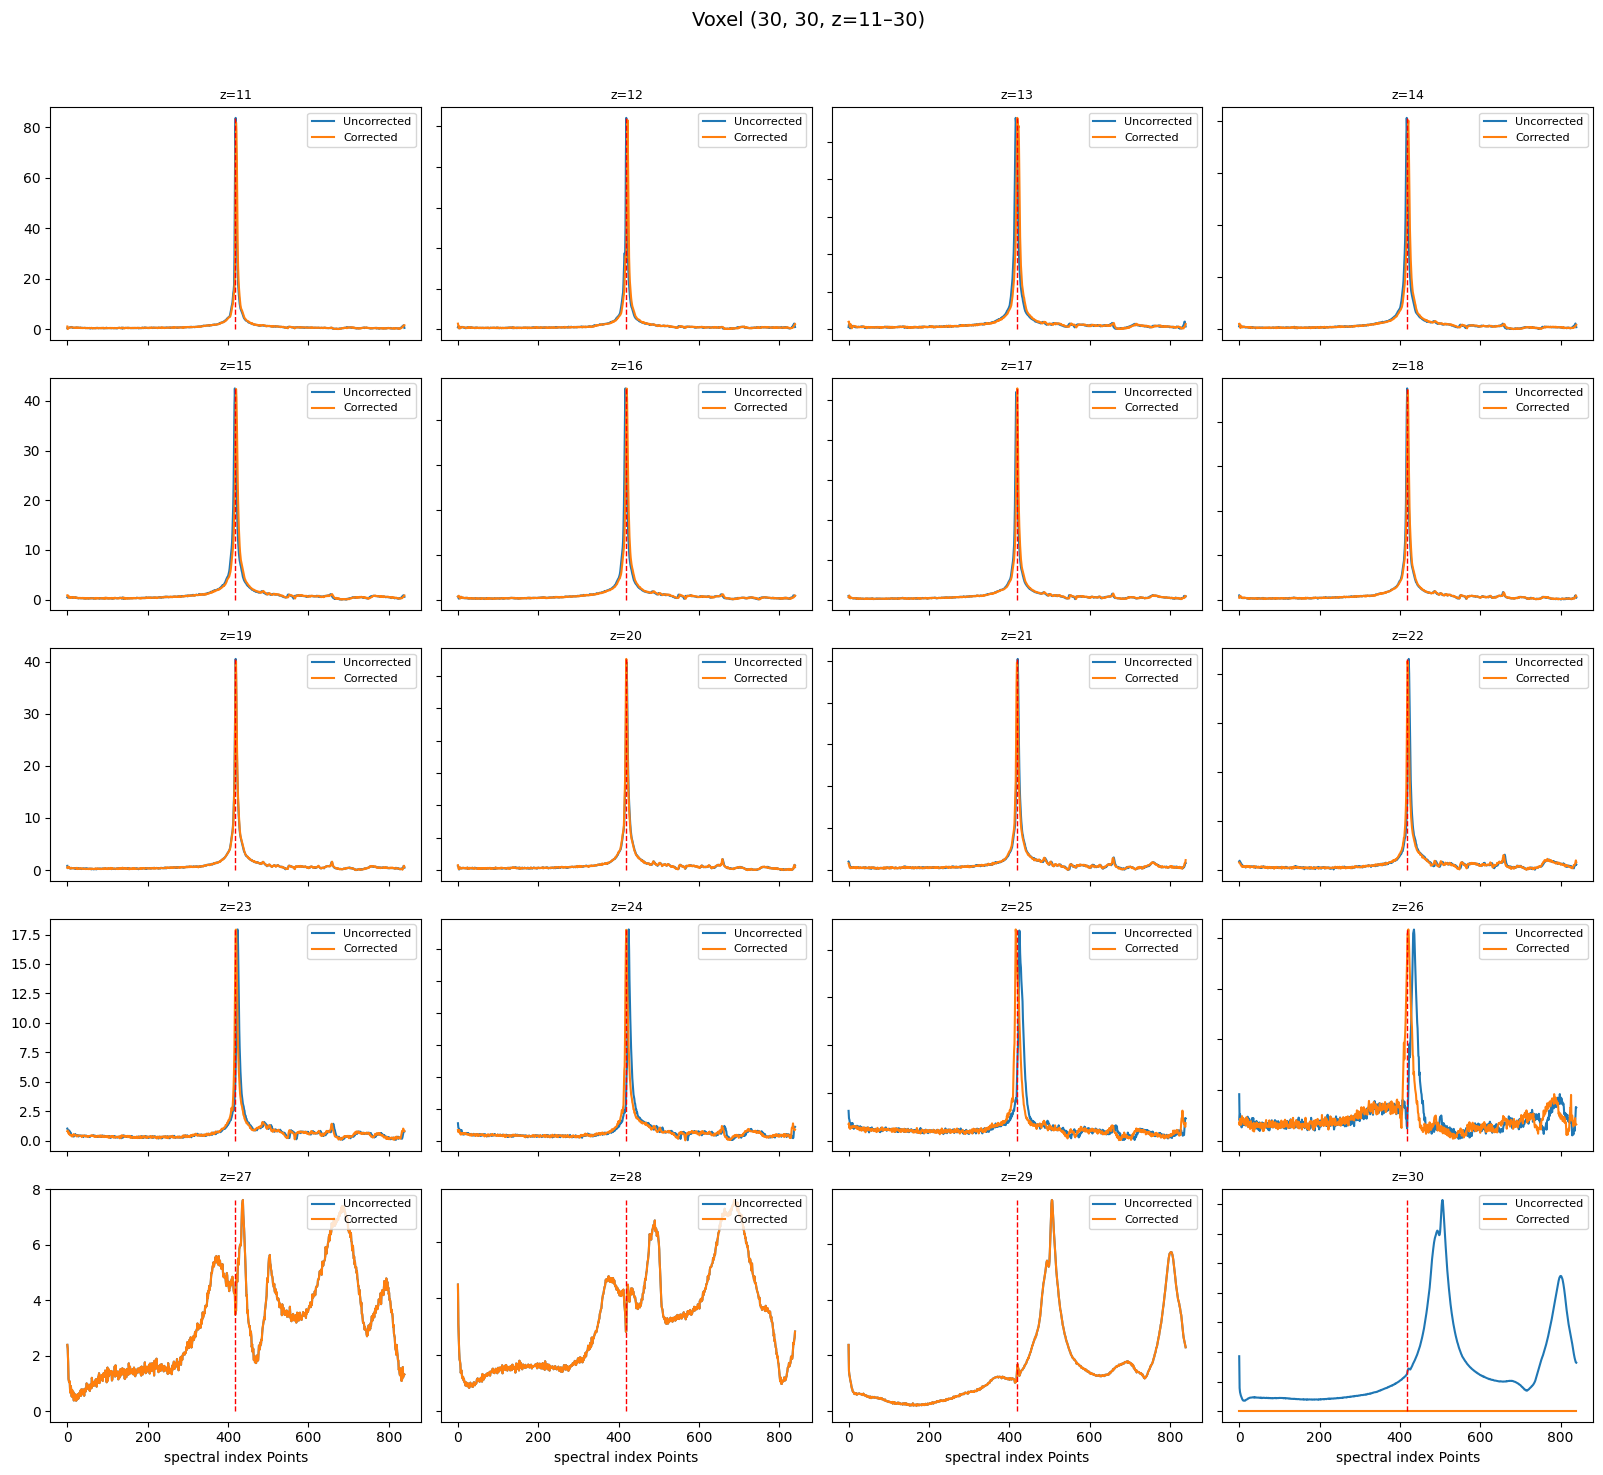

In [9]:
import matplotlib.pyplot as plt
import numpy as np

x, y = 30, 30
z_range = range(11, 31)   # 20 Slices

peak_index = 418

nrows, ncols = 5, 4   # 5x4 Grid
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3), sharex=True)

axes = axes.flatten()  # einfacher Zugriff auf alle Subplots

for i, z in enumerate(z_range):
    Line_1 = np.abs(uncorrected_ft)[x, y, z, :]
    Line_2 = np.abs(corrected_ft)[x, y, z, :]

    ax = axes[i]
    ax.plot(Line_1, label='Uncorrected')
    ax.plot(Line_2, label='Corrected')

    max_height = max(Line_1.max(), Line_2.max())
    ax.vlines(peak_index, ymin=0, ymax=max_height, color='red',
              linestyle='--', linewidth=1)

    ax.set_title(f'z={z}', fontsize=9)
    ax.legend(loc='upper right', fontsize=8)

# Nur außen Achsenlabels behalten
for ax in axes:
    ax.label_outer()

# X-Label nur in der letzten Reihe
for ax in axes[-ncols:]:
    ax.set_xlabel('spectral index Points')

fig.suptitle(f'Voxel ({x}, {y}, z=11–30)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig("voxel_plot_grid.png", dpi=300)
plt.show()


# Visualize B0 field

In [10]:
B_field = np.load(f'{Vol}/B0_estimation.npy')[...,0]
B_field = np.swapaxes(B_field, 0, 1)#*mask
B_field_masked = B_field*mask
B_field_masked_lipid = B_field*lipid_mask

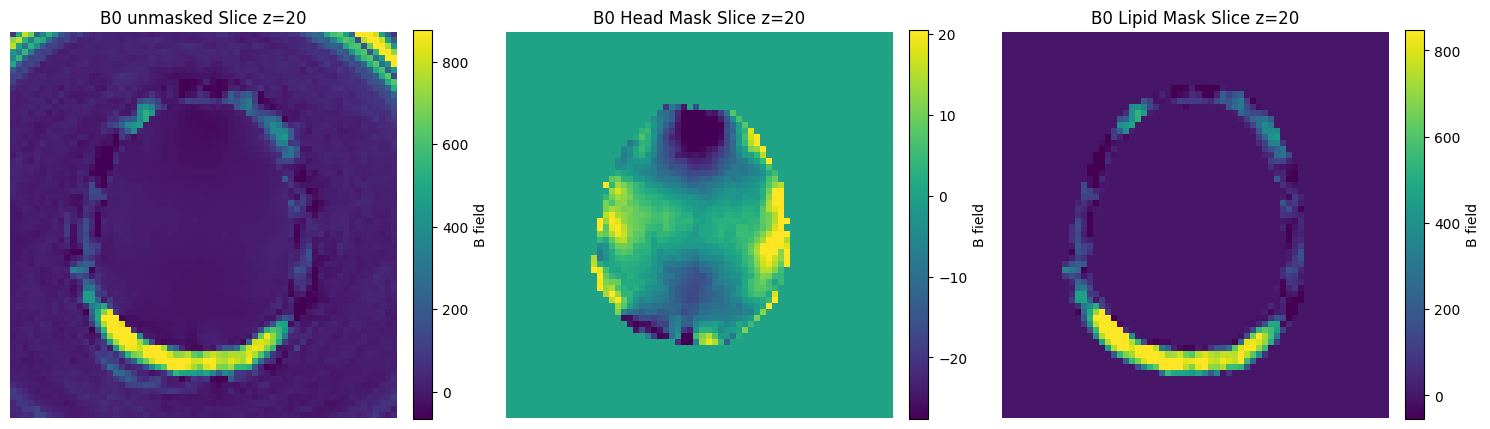

In [11]:
import numpy as np
import matplotlib.pyplot as plt

z = 20
Slice_1 = B_field[..., z]
Slice_2 = B_field_masked[..., z]
Slice_3 = B_field_masked_lipid[..., z]

# Clipping getrennt für jede Slice
vmin1, vmax1 = np.percentile(Slice_1, [1, 99])
vmin2, vmax2 = np.percentile(Slice_2, [1, 99])
vmin3, vmax3 = np.percentile(Slice_3, [1, 99])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im1 = axes[0].imshow(Slice_1, vmin=vmin1, vmax=vmax1, cmap='viridis')
axes[0].set_title(f'B0 unmasked Slice z={z}')
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04, label='B field')

im2 = axes[1].imshow(Slice_2, vmin=vmin2, vmax=vmax2, cmap='viridis')
axes[1].set_title(f'B0 Head Mask Slice z={z}')
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04, label='B field')

im3 = axes[2].imshow(Slice_3, vmin=vmin3, vmax=vmax3, cmap='viridis')
axes[2].set_title(f'B0 Lipid Mask Slice z={z}')
axes[2].axis('off')
fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04, label='B field')

plt.tight_layout()
plt.savefig("B0.png", dpi=300)

plt.show()